# Project - Data Science

## Fullname (nickname): Chalermchon Wongsopa (Im)

## Project Topic: Condominium Selection

---
## Current Situation / Problem Statement

As an non capital city citizen that want to find the glory of work life, we have to move to Bangkok and go get a job!.

After saving some money for many years, we are thinking about selecting a place to live properly. 

But what can we afford? ..
Yes, It must be condominium.

Then, Which area is the best choice? 
How much should we spend our money preciously? 

Let's find it together!


### This project will take you all to the data-driven decision making for condominium selection based on it's sale location






## Objectives:

1. To decide the worth location to buy a condominium
2. To understand price distribution of condominium price by differernt districts

## Hypothesis-driven Questions:


1.   Average condominium selling prices are different by districts



## Environment Preparation

In [ ]:
# install packages
!pip install geopy

In [ ]:
!pip install folium

In [ ]:
!pip install numpy_financial

In [ ]:
!pip install googlemaps

In [ ]:
!pip install simplejson

In [ ]:
!pip install --upgrade google-auth-oauthlib

In [1]:
import pandas as pd
import numpy as np
import folium # map visualization
import matplotlib.pyplot as plt # visualization
%matplotlib inline
from geopy.geocoders import Nominatim # location caculation
from geopy.extra.rate_limiter import RateLimiter # bulk requests for geopy
from geopy.distance import distance
import numpy_financial as npf
import googlemaps
import seaborn as sns

## Dataset:
1. Condominium selling price : Downloaded as csv from online source
2. Condominium rental price : Downloaded as csv from online source
3. District location (latitude, longitude) : Used geopy library

In [2]:
# read data
df_sell = pd.read_csv("./raw data/opendata_median_price.csv")
df_rent = pd.read_csv("./raw data/opendata_median_price_rent.csv")

In [3]:
# explore dataset - askprice

print(df_sell.shape)
df_sell.head()

(614, 11)


,row_number,transction_year,transction_month,listing_province_name_en,listing_province_name_th,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_asking_price_sqm
0,78,2019,7,BANGKOK,กรุงเทพมหานคร,ประเวศ,PRAWET,คอนโด,Condo,13,64971
1,342,2019,7,BANGKOK,กรุงเทพมหานคร,วัฒนา,VADHANA,คอนโด,Condo,128,173312
2,277,2020,12,BANGKOK,กรุงเทพมหานคร,จตุจักร,CHATUCHAK,คอนโด,Condo,23,109821
3,356,2021,1,BANGKOK,กรุงเทพมหานคร,พระโขนง,PHRA KHANONG,คอนโด,Condo,11,106412
4,598,2021,4,BANGKOK,กรุงเทพมหานคร,ราชเทวี,RATCHATHEWI,คอนโด,Condo,33,177486


In [4]:
# explore dataset - rentprice

print(df_rent.shape)
df_rent.head()

(1550, 11)


,row_number,transction_year,transction_month,listing_province_name_th,listing_province_name_en,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_rent_price_sqm
0,1037,2021,11,กรุงเทพมหานคร,BANGKOK,บางซื่อ,BANG SUE,คอนโด,Condo,118,336
1,575,2021,10,กรุงเทพมหานคร,BANGKOK,สาทร,SATHON,คอนโด,Condo,265,561
2,143,2019,11,กรุงเทพมหานคร,BANGKOK,บางกะปิ,BANG KAPI,คอนโด,Condo,262,393
3,530,2021,8,กรุงเทพมหานคร,BANGKOK,สวนหลวง,PHATTHANAKAN,คอนโด,Condo,24,268
4,319,2021,12,นนทบุรี,NONTHABURI,เมืองนนทบุรี,MUEANG NONTHABURI,คอนโด,Condo,267,251


In [5]:
# create distinct BKK district

# df_location = pd.DataFrame(set(df_sell['listing_district_name_en']), columns=['district'])
df_location = df_sell[['listing_province_name_en', 'listing_district_name_en']].drop_duplicates()
df_location.columns = ['province', 'district']

In [6]:
df_location.head()

,province,district
0,BANGKOK,PRAWET
1,BANGKOK,VADHANA
2,BANGKOK,CHATUCHAK
3,BANGKOK,PHRA KHANONG
4,BANGKOK,RATCHATHEWI


In [7]:
# set nominatim to delay finding location = 1 sec

geocoder = RateLimiter(Nominatim(user_agent='get_loc').geocode, min_delay_seconds = 1)
# df_location['location'] = df_location['district'].apply(geocoder)
df_location['location'] = df_location.apply(lambda loc : geocoder(loc.district + ', ' + loc.province + ', thailand'), axis=1)

In [8]:
df_location.head()

,province,district,location
0,BANGKOK,PRAWET,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (..."
1,BANGKOK,VADHANA,"(เขตวัฒนา, กรุงเทพมหานคร, 10110, ประเทศไทย, (1..."
2,BANGKOK,CHATUCHAK,"(เขตจตุจักร, กรุงเทพมหานคร, 10900, ประเทศไทย, ..."
3,BANGKOK,PHRA KHANONG,"(เขตพระโขนง, กรุงเทพมหานคร, 10260, ประเทศไทย, ..."
4,BANGKOK,RATCHATHEWI,"(เขตราชเทวี, กรุงเทพมหานคร, 10400, ประเทศไทย, ..."


In [9]:
# get lat, long from location using apply+lambda

df_location['lat'] = df_location['location'].apply(lambda loc: loc.latitude if loc else None)
df_location['long'] = df_location['location'].apply(lambda loc: loc.longitude if loc else None)

In [ ]:
# save data to directory

df_location.to_csv('./raw data/dist_location.csv', index=False)
# pd.read_csv("./raw data/dist_location.csv") # test saved data

In [10]:
df_location.head()

,province,district,location,lat,long
0,BANGKOK,PRAWET,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (...",13.721360,100.697808
1,BANGKOK,VADHANA,"(เขตวัฒนา, กรุงเทพมหานคร, 10110, ประเทศไทย, (1...",13.742793,100.560501
2,BANGKOK,CHATUCHAK,"(เขตจตุจักร, กรุงเทพมหานคร, 10900, ประเทศไทย, ...",13.803036,100.550230
3,BANGKOK,PHRA KHANONG,"(เขตพระโขนง, กรุงเทพมหานคร, 10260, ประเทศไทย, ...",13.702364,100.601546
4,BANGKOK,RATCHATHEWI,"(เขตราชเทวี, กรุงเทพมหานคร, 10400, ประเทศไทย, ...",13.753223,100.531860


In [11]:
df_location.isnull().sum()

province    0
district    0
location    0
lat         0
long        0
dtype: int64


## Data Preparation (Data Cleaning):


1. Select desired data and rename columns
2. Find missing values

#### Section 1 : Select desired data and rename columns

In [12]:
# explore dataset - sell
print(df_sell.shape)
df_sell.head()

(614, 11)


,row_number,transction_year,transction_month,listing_province_name_en,listing_province_name_th,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_asking_price_sqm
0,78,2019,7,BANGKOK,กรุงเทพมหานคร,ประเวศ,PRAWET,คอนโด,Condo,13,64971
1,342,2019,7,BANGKOK,กรุงเทพมหานคร,วัฒนา,VADHANA,คอนโด,Condo,128,173312
2,277,2020,12,BANGKOK,กรุงเทพมหานคร,จตุจักร,CHATUCHAK,คอนโด,Condo,23,109821
3,356,2021,1,BANGKOK,กรุงเทพมหานคร,พระโขนง,PHRA KHANONG,คอนโด,Condo,11,106412
4,598,2021,4,BANGKOK,กรุงเทพมหานคร,ราชเทวี,RATCHATHEWI,คอนโด,Condo,33,177486


In [13]:
# drop unnecessary columns

df_sell.drop(['row_number', 'listing_province_name_th', 'listing_district_name_th', 'project_propertytype_name_th'],
             axis=1,
             inplace=True
            )

In [14]:
df_sell.head()

,transction_year,transction_month,listing_province_name_en,listing_district_name_en,project_propertytype_name_en,total_listing,median_asking_price_sqm
0,2019,7,BANGKOK,PRAWET,Condo,13,64971
1,2019,7,BANGKOK,VADHANA,Condo,128,173312
2,2020,12,BANGKOK,CHATUCHAK,Condo,23,109821
3,2021,1,BANGKOK,PHRA KHANONG,Condo,11,106412
4,2021,4,BANGKOK,RATCHATHEWI,Condo,33,177486


In [15]:
# rename columns

df_sell.columns = ['year', 'month', 'province', 'district', 'prop_type', 'n', 'sell_price_sqm']

In [16]:
df_sell.head()

,year,month,province,district,prop_type,n,sell_price_sqm
0,2019,7,BANGKOK,PRAWET,Condo,13,64971
1,2019,7,BANGKOK,VADHANA,Condo,128,173312
2,2020,12,BANGKOK,CHATUCHAK,Condo,23,109821
3,2021,1,BANGKOK,PHRA KHANONG,Condo,11,106412
4,2021,4,BANGKOK,RATCHATHEWI,Condo,33,177486


In [17]:
# check value in categorical data

print('---Uniqiue value of caterical data---')
print('year:', df_sell.year.unique())
print('province:', df_sell.province.unique())
print('district:', df_sell.district.unique())
print('property type:', df_sell.prop_type.unique())

---Uniqiue value of caterical data---
year: [2019 2020 2021]
province: ['BANGKOK' 'NONTHABURI' 'SAMUT PRAKAN' 'PATHUM THANI']
district: ['PRAWET' 'VADHANA' 'CHATUCHAK' 'PHRA KHANONG' 'RATCHATHEWI' 'HUAI KHWANG'
 'BANG RAK' 'LAK SI' 'THON BURI' 'PAK KRET' 'MUEANG NONTHABURI' 'YAN NAWA'
 'SUAN LUANG' 'BANG PHLI' 'BANG NA' 'LAM LUK KA' 'KHLONG TOEI' 'BANG KAPI'
 'DIN DAENG' 'BANG KHAE' 'RAT BURANA' 'SATHON' 'BANG SUE' 'BUENG KUM'
 'PHASI CHAROEN' 'KHLONG SAN' 'PATHUM WAN' 'MUEANG SAMUT PRAKAN'
 'BANG KHO LAEM' 'LAT PHRAO' 'PHAYA THAI' 'BANG PHLAT' 'MIN BURI'
 'BANGKOK NOI' 'CHOM THONG' 'BANG KHEN' 'KHLONG SAM WA' 'WANG THONGLANG'
 'KHLONG LUANG' 'THANYABURI' 'BANGKOK YAI' 'BANG BUA THONG' 'SAI MAI']
property type: ['Condo' 'Detached House' 'Townhome']


In [18]:
# select only condo type

df_sell = df_sell[df_sell['prop_type'] == 'Condo']

In [19]:
print('property type:', df_sell.prop_type.unique())

property type: ['Condo']


In [20]:
# rental price

df_rent.head()

,row_number,transction_year,transction_month,listing_province_name_th,listing_province_name_en,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_rent_price_sqm
0,1037,2021,11,กรุงเทพมหานคร,BANGKOK,บางซื่อ,BANG SUE,คอนโด,Condo,118,336
1,575,2021,10,กรุงเทพมหานคร,BANGKOK,สาทร,SATHON,คอนโด,Condo,265,561
2,143,2019,11,กรุงเทพมหานคร,BANGKOK,บางกะปิ,BANG KAPI,คอนโด,Condo,262,393
3,530,2021,8,กรุงเทพมหานคร,BANGKOK,สวนหลวง,PHATTHANAKAN,คอนโด,Condo,24,268
4,319,2021,12,นนทบุรี,NONTHABURI,เมืองนนทบุรี,MUEANG NONTHABURI,คอนโด,Condo,267,251


In [21]:
# drop columns

df_rent.drop(['row_number', 'listing_province_name_th', 'listing_district_name_th', 'project_propertytype_name_th'],
             axis=1,
             inplace=True
            )

In [22]:
df_rent.head()

,transction_year,transction_month,listing_province_name_en,listing_district_name_en,project_propertytype_name_en,total_listing,median_rent_price_sqm
0,2021,11,BANGKOK,BANG SUE,Condo,118,336
1,2021,10,BANGKOK,SATHON,Condo,265,561
2,2019,11,BANGKOK,BANG KAPI,Condo,262,393
3,2021,8,BANGKOK,PHATTHANAKAN,Condo,24,268
4,2021,12,NONTHABURI,MUEANG NONTHABURI,Condo,267,251


In [23]:
# rename columns

df_rent.columns = ['year', 'month', 'province', 'district', 'prop_type', 'n', 'rent_price_sqm']

In [24]:
df_rent.head()

,year,month,province,district,prop_type,n,rent_price_sqm
0,2021,11,BANGKOK,BANG SUE,Condo,118,336
1,2021,10,BANGKOK,SATHON,Condo,265,561
2,2019,11,BANGKOK,BANG KAPI,Condo,262,393
3,2021,8,BANGKOK,PHATTHANAKAN,Condo,24,268
4,2021,12,NONTHABURI,MUEANG NONTHABURI,Condo,267,251


In [25]:
# check property type

df_rent['prop_type'].value_counts()

Condo             1495
Townhome            49
Detached House       5
Twin house           1
Name: prop_type, dtype: int64

In [26]:
# select only condo type

df_rent = df_rent[df_rent['prop_type'] == 'Condo']

In [27]:
df_rent.head()

,year,month,province,district,prop_type,n,rent_price_sqm
0,2021,11,BANGKOK,BANG SUE,Condo,118,336
1,2021,10,BANGKOK,SATHON,Condo,265,561
2,2019,11,BANGKOK,BANG KAPI,Condo,262,393
3,2021,8,BANGKOK,PHATTHANAKAN,Condo,24,268
4,2021,12,NONTHABURI,MUEANG NONTHABURI,Condo,267,251


#### Section 2 : Check missing values

In [28]:
# check missing values

df_sell.isnull().sum()

year              0
month             0
province          0
district          0
prop_type         0
n                 0
sell_price_sqm    0
dtype: int64

In [29]:
df_rent.isnull().sum()

year              0
month             0
province          0
district          0
prop_type         0
n                 0
rent_price_sqm    0
dtype: int64

## Exploratory Data Analysis (EDA):

In [30]:
df_sell.head()

,year,month,province,district,prop_type,n,sell_price_sqm
0,2019,7,BANGKOK,PRAWET,Condo,13,64971
1,2019,7,BANGKOK,VADHANA,Condo,128,173312
2,2020,12,BANGKOK,CHATUCHAK,Condo,23,109821
3,2021,1,BANGKOK,PHRA KHANONG,Condo,11,106412
4,2021,4,BANGKOK,RATCHATHEWI,Condo,33,177486


#### Section 1

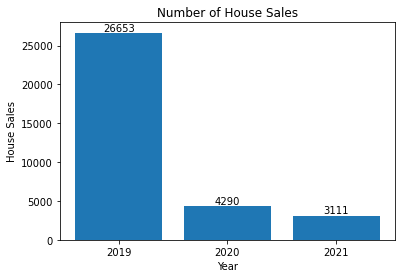

In [31]:
# Number of house sales by year

x = [str(x) for x in list(df_sell.groupby('year').sum().index)]
y = df_sell.groupby('year').sum().n

fig, ax = plt.subplots()

bars = plt.bar(x, y)
plt.title('Number of House Sales')
plt.xlabel('Year')
plt.ylabel('House Sales')
ax.bar_label(bars)

plt.show()


In [32]:
df_sell.groupby('year').apply(lambda x : np.average(x.sell_price_sqm, weights=x.n)).map('{:,.2f}'.format)

year
2019    146,788.78
2020    112,945.16
2021    160,019.12
dtype: object

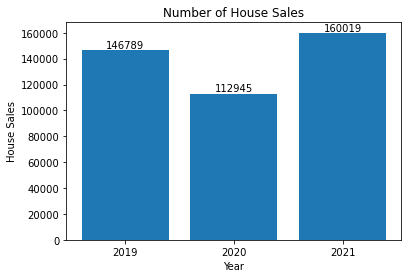

In [33]:
# Avg.salse price by year

x = [str(x) for x in list(df_sell.groupby('year').sum().index)]
y = df_sell.groupby('year').apply(lambda x : np.average(x.sell_price_sqm, weights=x.n))

fig, ax = plt.subplots()

bars = plt.bar(x, y)
plt.title('Number of House Sales')
plt.xlabel('Year')
plt.ylabel('House Sales')
ax.bar_label(bars)

plt.show()


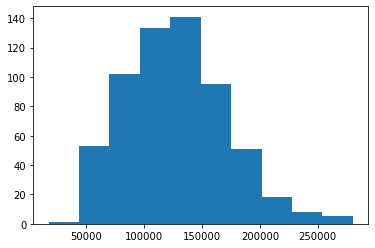

In [34]:
# selling price distribution

plt.hist(df_sell['sell_price_sqm'])
plt.show()

In [35]:
# number of unique districts by year

df_sell.groupby('year').district.nunique()

year
2019    38
2020    35
2021    16
Name: district, dtype: int64

#### Section 2

In [36]:
# create Avg.price by district table

df_sell_dist = pd.DataFrame(df_sell.groupby('district').apply(lambda x : np.average(x.sell_price_sqm, weights=x.n)),
            columns=['sell_price_sqm']).reset_index()

# merge number of salse by district
df_sell_dist = pd.merge(df_sell_dist, pd.DataFrame(df_sell.groupby('district').sum().n), on='district', how='left')


# merge with locaiton data
df_sell_dist = pd.merge(df_sell_dist, df_location, on='district', how='left')

In [37]:
# esitmate price for 30 sqm room size

df_sell_dist['sell_price_30sqm'] = df_sell_dist.sell_price_sqm * 30 / 1000000

In [38]:
df_sell_dist.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330
1,BANG KAPI,96240.100352,568,BANGKOK,"(เขตบางกะปิ, กรุงเทพมหานคร, ประเทศไทย, (13.764...",13.764000,100.644808,2.887203
2,BANG KHAE,81168.653061,49,BANGKOK,"(เขตบางแค, กรุงเทพมหานคร, 10160, ประเทศไทย, (1...",13.710743,100.420823,2.435060
3,BANG KHEN,79196.206349,126,BANGKOK,"(บางเขน, ถนนกำแพงเพชร 6, แขวงลาดยาว, เขตจตุจัก...",13.847000,100.560620,2.375886
4,BANG KHO LAEM,126766.478723,94,BANGKOK,"(2351 Soi Charoen Krung 91, Khwaeng Wat Phraya...",13.704162,100.505343,3.802994


In [39]:
loc_bangkok = geocoder('Bangkok')
print(loc_bangkok)

กรุงเทพมหานคร, 10200, ประเทศไทย


In [40]:
print("Most expensive condo district\n",
      "District: ",
      df_sell_dist[df_sell_dist.sell_price_sqm == df_sell_dist.sell_price_sqm.max()].iloc[0].district,
      "\nPrice (30sqm): ",
      round(df_sell_dist[df_sell_dist.sell_price_sqm == df_sell_dist.sell_price_sqm.max()].iloc[0].sell_price_30sqm,2),
      'MB.'
     )

Most expensive condo district
 District:  BANG RAK 
Price (30sqm):  5.81 MB.


In [41]:
print("Lest expensive condo district\n",
      "District: ",
      df_sell_dist[df_sell_dist.sell_price_sqm == df_sell_dist.sell_price_sqm.min()].iloc[0].district,
      "\nPrice (30sqm): ",
      round(df_sell_dist[df_sell_dist.sell_price_sqm == df_sell_dist.sell_price_sqm.min()].iloc[0].sell_price_30sqm, 2),
      'MB.'
     )

Lest expensive condo district
 District:  LAT PHRAO 
Price (30sqm):  1.6 MB.


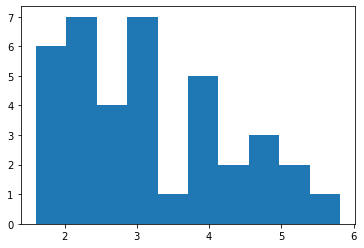

In [42]:
# selling price distribution by districts

plt.hist(df_sell_dist.sell_price_30sqm)
plt.show()

In [43]:
# color data by range of selling price

def price_color(price):
    if price < 2:
        return 'lightgreen'
    elif price < 3:
        return 'darkgreen'
    elif price < 4:
        return 'orange'
    elif price < 5:
        return 'red'
    elif price < 6:
        return 'darkred'
    
df_sell_dist['sell_color_code'] = df_sell_dist.sell_price_30sqm.apply(price_color)

In [44]:
df_sell_dist.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen
1,BANG KAPI,96240.100352,568,BANGKOK,"(เขตบางกะปิ, กรุงเทพมหานคร, ประเทศไทย, (13.764...",13.764000,100.644808,2.887203,darkgreen
2,BANG KHAE,81168.653061,49,BANGKOK,"(เขตบางแค, กรุงเทพมหานคร, 10160, ประเทศไทย, (1...",13.710743,100.420823,2.435060,darkgreen
3,BANG KHEN,79196.206349,126,BANGKOK,"(บางเขน, ถนนกำแพงเพชร 6, แขวงลาดยาว, เขตจตุจัก...",13.847000,100.560620,2.375886,darkgreen
4,BANG KHO LAEM,126766.478723,94,BANGKOK,"(2351 Soi Charoen Krung 91, Khwaeng Wat Phraya...",13.704162,100.505343,3.802994,orange


In [79]:
# create bkk map
bk_map = folium.Map(
    location = [loc_bangkok.latitude, loc_bangkok.longitude],
    zoom_start = 12,
    tiles='cartodbpositron',
)

# plot district location
for (index, row) in df_sell_dist.iterrows():
    iframe = folium.IFrame('District name: ' + row.loc['district'] + '<br>' * 2+ \
                           'AVG. Price: ' + str(round(row.loc['sell_price_30sqm'],2)) + ' MB')
    popup = folium.Popup(iframe, min_width=300, max_width=300)
    folium.Marker(location = [row.loc['lat'], row.loc['long']],
                  popup = popup,
                  icon = folium.Icon(color=row.loc['sell_color_code'])
                 ).add_to(bk_map)



In [80]:
bk_map

In [47]:
# calculate monthly mortgage paymennt
# 20 years of payment periods
# 6.24% yearly interest rate

df_sell_dist['pmt'] = df_sell_dist.apply(lambda row : -round(npf.pmt(0.0624/12, 20*12, row.sell_price_30sqm*1000000), 2), axis=1)

In [48]:
df_sell_dist.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37
1,BANG KAPI,96240.100352,568,BANGKOK,"(เขตบางกะปิ, กรุงเทพมหานคร, ประเทศไทย, (13.764...",13.764000,100.644808,2.887203,darkgreen,21086.56
2,BANG KHAE,81168.653061,49,BANGKOK,"(เขตบางแค, กรุงเทพมหานคร, 10160, ประเทศไทย, (1...",13.710743,100.420823,2.435060,darkgreen,17784.35
3,BANG KHEN,79196.206349,126,BANGKOK,"(บางเขน, ถนนกำแพงเพชร 6, แขวงลาดยาว, เขตจตุจัก...",13.847000,100.560620,2.375886,darkgreen,17352.18
4,BANG KHO LAEM,126766.478723,94,BANGKOK,"(2351 Soi Charoen Krung 91, Khwaeng Wat Phraya...",13.704162,100.505343,3.802994,orange,27775.00


In [49]:
# calculate distance to working area
# get True Digital Park location

true_loc = geocoder('True digital park 101')

In [50]:
# add distance to location dataframe

df_location['true_distance'] = df_location.apply(lambda loc : distance((true_loc.latitude, true_loc.longitude), (loc.lat, loc.long)).km, axis=1)

In [51]:
df_location.head()

,province,district,location,lat,long,true_distance
0,BANGKOK,PRAWET,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (...",13.721360,100.697808,10.159732
1,BANGKOK,VADHANA,"(เขตวัฒนา, กรุงเทพมหานคร, 10110, ประเทศไทย, (1...",13.742793,100.560501,8.382572
2,BANGKOK,CHATUCHAK,"(เขตจตุจักร, กรุงเทพมหานคร, 10900, ประเทศไทย, ...",13.803036,100.550230,14.577390
3,BANGKOK,PHRA KHANONG,"(เขตพระโขนง, กรุงเทพมหานคร, 10260, ประเทศไทย, ...",13.702364,100.601546,2.136037
4,BANGKOK,RATCHATHEWI,"(เขตราชเทวี, กรุงเทพมหานคร, 10400, ประเทศไทย, ...",13.753223,100.531860,11.395239


In [52]:
# create transportation cost calculation function (TDA vs district)
# return monthly average cost
# assumed 260 working day in 2022 - 19 public holidays = 241 days/year -> 20 days/months
# engine fuel consumtion = 15 km / 1 litter
# fuel price based on E20 price ~ 37 THB / 1 litter

def tran_cost(distance, days=20, fuel_consum=15, fuel_price=37, round_trip=True):
    if round_trip == True:
        return distance * days / fuel_consum * fuel_price * 2
    else:
        return distance * days / fuel_consum * fuel_price

In [53]:
df_location['true_transcost'] = df_location.true_distance.apply(tran_cost)

In [54]:
df_location.head()

,province,district,location,lat,long,true_distance,true_transcost
0,BANGKOK,PRAWET,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (...",13.721360,100.697808,10.159732,1002.426909
1,BANGKOK,VADHANA,"(เขตวัฒนา, กรุงเทพมหานคร, 10110, ประเทศไทย, (1...",13.742793,100.560501,8.382572,827.080408
2,BANGKOK,CHATUCHAK,"(เขตจตุจักร, กรุงเทพมหานคร, 10900, ประเทศไทย, ...",13.803036,100.550230,14.577390,1438.302438
3,BANGKOK,PHRA KHANONG,"(เขตพระโขนง, กรุงเทพมหานคร, 10260, ประเทศไทย, ...",13.702364,100.601546,2.136037,210.755666
4,BANGKOK,RATCHATHEWI,"(เขตราชเทวี, กรุงเทพมหานคร, 10400, ประเทศไทย, ...",13.753223,100.531860,11.395239,1124.330215


In [55]:
df_sell_dist.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37
1,BANG KAPI,96240.100352,568,BANGKOK,"(เขตบางกะปิ, กรุงเทพมหานคร, ประเทศไทย, (13.764...",13.764000,100.644808,2.887203,darkgreen,21086.56
2,BANG KHAE,81168.653061,49,BANGKOK,"(เขตบางแค, กรุงเทพมหานคร, 10160, ประเทศไทย, (1...",13.710743,100.420823,2.435060,darkgreen,17784.35
3,BANG KHEN,79196.206349,126,BANGKOK,"(บางเขน, ถนนกำแพงเพชร 6, แขวงลาดยาว, เขตจตุจัก...",13.847000,100.560620,2.375886,darkgreen,17352.18
4,BANG KHO LAEM,126766.478723,94,BANGKOK,"(2351 Soi Charoen Krung 91, Khwaeng Wat Phraya...",13.704162,100.505343,3.802994,orange,27775.00


In [56]:
df_sell_dist = pd.merge(df_sell_dist, df_location[['district', 'true_distance', 'true_transcost']], on='district', how='left')

In [57]:
df_sell_dist['monthly_exp'] = df_sell_dist['pmt'] + df_sell_dist['true_transcost']

In [58]:
df_sell_dist.sort_values(by='monthly_exp').head(5)

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt,true_distance,true_transcost,monthly_exp
20,LAT PHRAO,53370.444444,36,BANGKOK,"(เขตลาดพร้าว, กรุงเทพมหานคร, 10230, ประเทศไทย,...",13.803679,100.590874,1.601113,lightgreen,11693.66,13.251591,1307.490354,13001.150354
36,WANG THONGLANG,57251.750000,36,BANGKOK,"(เขตวังทองหลาง, กรุงเทพมหานคร, 10310, ประเทศไท...",13.767821,100.598274,1.717553,lightgreen,12544.07,9.207322,908.455807,13452.525807
12,BUENG KUM,58505.024390,41,BANGKOK,"(เขตบึงกุ่ม, กรุงเทพมหานคร, ประเทศไทย, (13.785...",13.785357,100.668631,1.755151,lightgreen,12818.66,12.660766,1249.195601,14067.855601
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37,31.786322,3136.250464,14882.620464
29,PRAWET,64662.887931,116,BANGKOK,"(เขตประเวศ, กรุงเทพมหานคร, 10250, ประเทศไทย, (...",13.721360,100.697808,1.939887,lightgreen,14167.87,10.159732,1002.426909,15170.296909


In [59]:
# filter <= 10 km distance to TDA

df_near_true_dist = df_sell_dist[df_sell_dist['true_distance'] <= 10].sort_values(by='monthly_exp')

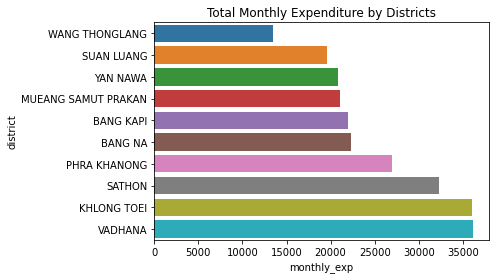

In [60]:
x = df_near_true_dist.monthly_exp
y = df_near_true_dist.district

sns.barplot(x=x, y=y)
plt.title("Total Monthly Expenditure by Districts")
plt.show()

In [61]:
# create bkk map
bk_map_near_true = folium.Map(
    location = [loc_bangkok.latitude, loc_bangkok.longitude],
    zoom_start = 12,
    tiles='cartodbpositron',
)

# plot district location
for (index, row) in df_near_true_dist.iterrows():
    iframe = folium.IFrame('District name: ' + row.loc['district'] + '<br>' * 2+ 
                           'AVG. Price: ' + str(round(row.loc['sell_price_30sqm'],2)) + ' MB' +
                          '<br>' + 'Monthly installment: ' + str('{:,.2f}'.format(round(row.loc['pmt'],2))) + ' THB' + 
                          '<br>' + 'Transportation cost: ' + str('{:,.2f}'.format(round(row.loc['true_transcost'],2))) + ' THB' +
                           '<br>' + 'Total monthly expenditure: ' + str('{:,.2f}'.format(round(row.loc['monthly_exp'],2))) + ' THB'
                          )
    popup = folium.Popup(iframe, min_width=300, max_width=300)
    folium.Marker(location = [row.loc['lat'], row.loc['long']],
                  popup = popup,
                  icon = folium.Icon(color=row.loc['sell_color_code'])
                 ).add_to(bk_map_near_true)

# add true digital park to map
folium.Marker(location = [true_loc.latitude, true_loc.longitude],
              icon = folium.Icon(color='blue')
             ).add_to(bk_map_near_true)

In [62]:
bk_map_near_true

#### Section 3 : Condominuims for rental purpose

In [63]:
df_rent.year.unique()

array([2021, 2019, 2020, 2022], dtype=int64)

In [64]:
df_rent[df_rent.year != 2022].district.nunique()

54

In [65]:
df_rent.head()

,year,month,province,district,prop_type,n,rent_price_sqm
0,2021,11,BANGKOK,BANG SUE,Condo,118,336
1,2021,10,BANGKOK,SATHON,Condo,265,561
2,2019,11,BANGKOK,BANG KAPI,Condo,262,393
3,2021,8,BANGKOK,PHATTHANAKAN,Condo,24,268
4,2021,12,NONTHABURI,MUEANG NONTHABURI,Condo,267,251


In [66]:
df_rent_dist = pd.DataFrame(df_rent[df_rent.year != 2022].groupby('district').apply(
    lambda x : np.average(x.rent_price_sqm, weights=x.n)), columns=['rent_price_sqm']).reset_index()

In [67]:
df_rent_dist['rent_price_30sqm'] = df_rent_dist['rent_price_sqm'] * 30 

In [68]:
df_rent_dist.sort_values(by='rent_price_sqm', ascending=False).head()

,district,rent_price_sqm,rent_price_30sqm
36,PATHUM WAN,741.500845,22245.025338
51,VADHANA,641.661337,19249.840122
11,BANG RAK,633.014461,18990.433826
26,KHLONG TOEI,626.650585,18799.517551
47,SATHON,573.575438,17207.263144


In [69]:
df_sell_dist = pd.merge(df_sell_dist, df_rent_dist[['district', 'rent_price_30sqm']], on='district', how='left')

In [70]:
df_sell_dist.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt,true_distance,true_transcost,monthly_exp,rent_price_30sqm
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37,31.786322,3136.250464,14882.620464,7015.485782
1,BANG KAPI,96240.100352,568,BANGKOK,"(เขตบางกะปิ, กรุงเทพมหานคร, ประเทศไทย, (13.764...",13.764000,100.644808,2.887203,darkgreen,21086.56,9.402288,927.692394,22014.252394,9995.551011
2,BANG KHAE,81168.653061,49,BANGKOK,"(เขตบางแค, กรุงเทพมหานคร, 10160, ประเทศไทย, (1...",13.710743,100.420823,2.435060,darkgreen,17784.35,20.792558,2051.532359,19835.882359,8381.250000
3,BANG KHEN,79196.206349,126,BANGKOK,"(บางเขน, ถนนกำแพงเพชร 6, แขวงลาดยาว, เขตจตุจัก...",13.847000,100.560620,2.375886,darkgreen,17352.18,18.681258,1843.217481,19195.397481,8684.242567
4,BANG KHO LAEM,126766.478723,94,BANGKOK,"(2351 Soi Charoen Krung 91, Khwaeng Wat Phraya...",13.704162,100.505343,3.802994,orange,27775.00,11.645598,1149.032384,28924.032384,12107.084469


In [71]:
df_sell_dist['rent_pay'] = df_sell_dist['rent_price_30sqm'] / df_sell_dist['pmt']

In [72]:
# create top return/installment
df_top_return = df_sell_dist.sort_values(by='rent_pay', ascending=False).head(10)

In [73]:
df_top_return.head()

,district,sell_price_sqm,n,province,location,lat,long,sell_price_30sqm,sell_color_code,pmt,true_distance,true_transcost,monthly_exp,rent_price_30sqm,rent_pay
20,LAT PHRAO,53370.444444,36,BANGKOK,"(เขตลาดพร้าว, กรุงเทพมหานคร, 10230, ประเทศไทย,...",13.803679,100.590874,1.601113,lightgreen,11693.66,13.251591,1307.490354,13001.150354,9493.080357,0.811814
36,WANG THONGLANG,57251.750000,36,BANGKOK,"(เขตวังทองหลาง, กรุงเทพมหานคร, 10310, ประเทศไท...",13.767821,100.598274,1.717553,lightgreen,12544.07,9.207322,908.455807,13452.525807,8751.611374,0.697669
21,MIN BURI,65595.000000,12,BANGKOK,"(แขวงมีนบุรี, เขตมีนบุรี, กรุงเทพมหานคร, 10510...",13.812467,100.728348,1.967850,lightgreen,14372.10,18.902316,1865.028492,16237.128492,9017.352941,0.627421
7,BANG PHLI,77397.328767,73,SAMUT PRAKAN,"(เทศบาลตำบลบางพลี, อำเภอบางพลี, จังหวัดสมุทรปร...",13.607126,100.707883,2.321920,darkgreen,16958.04,13.584029,1340.290817,18298.330817,10367.512847,0.611363
0,BANG BUA THONG,53611.000000,17,NONTHABURI,"(Modi Villa Chaiyapruk, Phimon Rat, Bang Bua T...",13.917899,100.438353,1.608330,lightgreen,11746.37,31.786322,3136.250464,14882.620464,7015.485782,0.597247


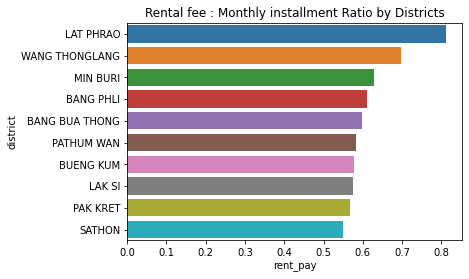

In [74]:
x = df_top_return.rent_pay
y = df_top_return.district

sns.barplot(x=x, y=y)
plt.title("Rental fee : Monthly installment Ratio by Districts")
plt.show()

In [75]:
# create bkk map
bk_map_rent = folium.Map(
    location = [loc_bangkok.latitude, loc_bangkok.longitude],
    zoom_start = 12,
    tiles='cartodbpositron',
)

# plot district location
for (index, row) in df_top_return.iterrows():
    iframe = folium.IFrame('District name: ' + row.loc['district'] + '<br>' * 2+ 
                           'AVG. Price: ' + str(round(row.loc['sell_price_30sqm'],2)) + ' MB' +
                          '<br>' + 'Monthly installment: ' + str('{:,.2f}'.format(round(row.loc['pmt'],2))) + ' THB' + 
                          '<br>' + 'Rental price: ' + str('{:,.2f}'.format(round(row.loc['rent_price_30sqm'],2))) + ' THB' +
                           '<br>' + 'Rental:Installment ratio: ' + str('{:,.2f}'.format(round(row.loc['rent_pay'],2) * 100) + ' %')
                          )
    popup = folium.Popup(iframe, min_width=300, max_width=300)
    folium.Marker(location = [row.loc['lat'], row.loc['long']],
                  popup = popup,
                  icon = folium.Icon(color=row.loc['sell_color_code'])
                 ).add_to(bk_map_rent)



In [76]:
bk_map_rent

## Key Findings:


1. Lat Phrao is the best district for investment
2. Wang Thonglang is the most valued choice for working at TDA

<div class="alert alert-info">
<h3>What’s Next / Recommendation:</h3>
</div>


1. Data in this model are modified by 3rd party provider and not precise enough to make a decision
2. Other factors should be taken into account such as condo facilities, name of project owners, public transportation, and quality of living

<div class="alert alert-info">
<h3>Financial Benefit:</h3>
</div>


1. Decrease NPL from buying overpriced condominiums

<div class="alert alert-info">
<h3>Non-Financial Benefit:</h3>
</div>


1. Decrease time for condominium selection
2. Chose the right location for each purpose of invesment